In [1]:
import pandas
#pandas.options.display.max_colwidth = None #set_option('max_colwidth', None)
#pandas.options.display.max_columns = 20#None#(100)#set_option('max_columns', None)

import numpy
import pygsheets
import datetime
import scipy
import sklearn.linear_model
import sklearn.cluster
import re

import matplotlib.pyplot as mp
import matplotlib

# import pipelines dataset

In [2]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1PKsCoVnfnCEalDBOF0Fmny0-pg1qy86DoReNHI-97WM')

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = gas_pipes.copy()

# remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.PipelineName!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Wiki!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Fuel.isin(['Gas','Hydrogen'])]

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [3]:
country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--',numpy.nan,inplace=True)
pipes_df_orig['ProposalYear'] = pipes_df_orig['ProposalYear'].replace('',numpy.nan)
region_df_orig = spreadsheet.worksheet('title', 'Region dictionary').get_as_df(start='A2')

In [4]:
region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
region_df_egt = region_df_orig.copy()[region_df_orig['EuroGasTracker']=='Yes']
region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
region_df_eu_uk = region_df_orig.copy()[(region_df_orig['Region']=='Europe') | 
                                          (region_df_orig['Country'].isin(['United Kingdom','Israel']))]

In [5]:
region_df_touse = region_df_eu.copy()

In [6]:
# subset the pipelines to use
# can't use pipes_df_touse... because some of the pipelines get eliminated if they're not in the same country...
pipes_df_touse = pipes_df_orig.loc[
    ~pipes_df_orig['Countries'].apply(
        lambda x: set(x.split(', ')).isdisjoint(set(region_df_touse['Country'].tolist()))
    )]

pipes_df_touse_h2 = pipes_df_touse.loc[(pipes_df_touse.Fuel=='Hydrogen')|
                                       (pipes_df_touse.H2Status!='')]
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.Fuel=='Gas']
pipes_df_orig_gas = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')]
country_ratios_df_touse = country_ratios_df.loc[#(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
                                                (country_ratios_df.Fuel=='Gas')]

In [7]:
western_eu = ['Ireland', 'France', 'Belgium', 'Netherlands', 
              'Luxembourg', 'Germany', 'Austria'] 

eastern_eu = ['Estonia', 'Latvia', 'Lithuania', 'Poland', 'Czech Republic', 
              'Slovakia', 'Slovenia', 'Croatia', 'Hungary', 'Romania', 'Bulgaria'] 

southern_eu = ['Portugal', 'Spain', 'Italy', 
               'Malta', 'Greece', 'Cyprus']

northern_eu = ['Sweden', 'Finland', 'Denmark']

# cost estimates for EU 27 member states

## outliers and special cases

### correct Poland-Ukraine Interconnector

In [8]:
# https://www.gem.wiki/Poland-Ukraine_Interconnector_Gas_Pipeline
# our country_ratios code calculates this is half in each country, but it's not
country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_touse.Country=='Poland'),'MergedKmByCountry'] = 1.5

country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_touse.Country=='Ukraine'),'MergedKmByCountry'] = 99.0

### correct Gas Interconnection Poland-Lithuania (our fractional calc doesn't get it right)

In [9]:
country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_touse.Country=='Poland'),'MergedKmByCountry'] = 343.0

country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_touse.Country=='Lithuania'),'MergedKmByCountry'] = 165.0

cost exploring

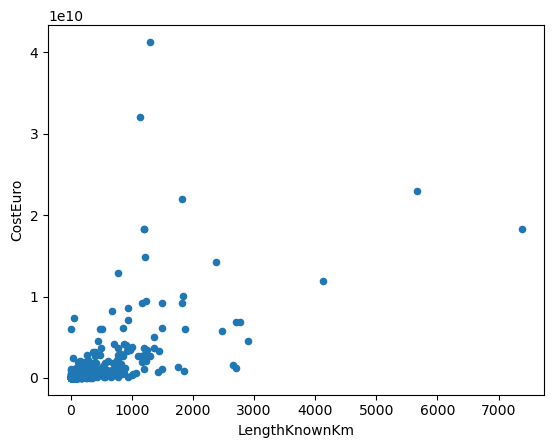

In [10]:
ax = pipes_df_orig.plot.scatter('LengthKnownKm','CostEuro')

### regression estimate: given length, estimate cost

In [11]:
pipes_df_toregress = pipes_df_touse.loc[(~pipes_df_touse.LengthKnownKm.isnull())&
                                       (~pipes_df_touse.CostEuro.isnull())&
                                       (pipes_df_touse.LengthKnownKm>0)]

# calculate projects with same name/cost, drop the first of the same pipeline names...
same_name_and_cost = pipes_df_toregress.loc[(pipes_df_toregress.duplicated('CostEuroPerKm'))&
                       (pipes_df_toregress.duplicated('PipelineName'))].drop_duplicates('PipelineName', keep='first')
pipes_df_toregress_dropdupes = pipes_df_toregress.drop(same_name_and_cost.index)

# # look at the full global dataset
# pipes_df_toregress = pipes_df_orig.loc[(~pipes_df_orig.LengthKnownKm.isnull())&
#                                         (~pipes_df_orig.CostEuro.isnull())&
#                                         (pipes_df_orig.LengthKnownKm!=0)]#&
#                                         #(pipes_df_orig.LengthKnownKm>100)&
#                                         #(pipes_df_orig.LengthKnownKm<1000)]

### gentle cluster analysis

In [12]:
num_clusters = 2
kmeans_cluster = sklearn.cluster.KMeans(n_clusters=num_clusters, 
                                        init='random', 
                                        n_init=10, 
                                        max_iter=300, 
                                        tol=1e-4,
                                       random_state=42)

km_fit = kmeans_cluster.fit_predict(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                   y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

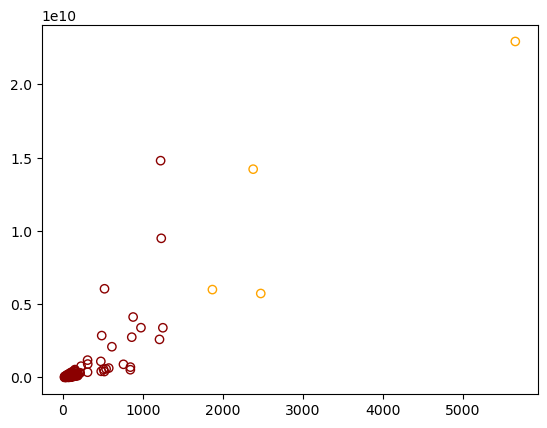

In [13]:
colors=['darkred','orange','green','blue','purple']

for i in range(num_clusters):
    mp.scatter(pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1)[km_fit == i],
               pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1)[km_fit == i],
               edgecolor=colors[i], color='None')

#mp.xlim(0,1000)
#mp.ylim(0,0.5e10)
# mp.scatter(pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1)[km_fit == 2],
#            pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1)[km_fit == 2],
#            color='slateblue', s=10)

In [14]:
ts_estimator = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                 y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

r_estimator = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

ols_estimator = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                  y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

ts_slope, ts_intercept, ts_low_slope, ts_high_slope = scipy.stats.mstats.theilslopes(y=pipes_df_toregress_dropdupes.CostEuro.tolist(), 
                                                                                     x=pipes_df_toregress_dropdupes.LengthKnownKm.tolist(),
                                                                                     alpha=0.1, )

s_slope, s_intercept = scipy.stats.mstats.siegelslopes(y=pipes_df_toregress_dropdupes.CostEuro.tolist(), 
                                                       x=pipes_df_toregress_dropdupes.LengthKnownKm.tolist())

/Users/baird/mambaforge/envs/gem/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[4.01993203]] OLS
[1.21497253] TS
[[1.13243081]] R
1.9555555555555555 scipy TS slope
2.0004776767976344 straight-up mean


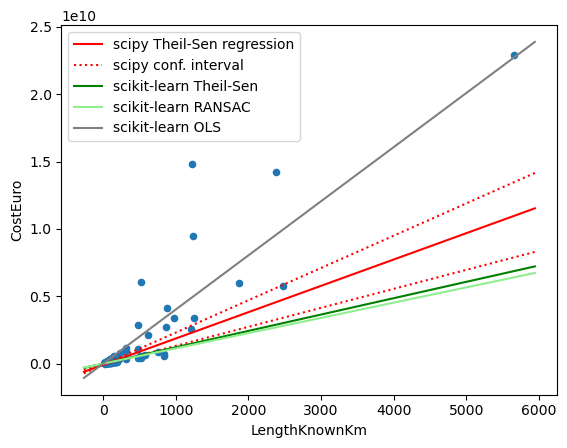

In [15]:
ax = pipes_df_toregress_dropdupes.plot.scatter('LengthKnownKm','CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred = ts_estimator.predict(xvals.reshape(-1,1))
r_pred = r_estimator.predict(xvals.reshape(-1,1))
ols_pred = ols_estimator.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope*xvals+ts_intercept, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope*xvals+ts_intercept, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope*xvals+ts_intercept, c='red', ls=':')

ax.plot(xvals, ts_pred, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred, label='scikit-learn OLS', c='gray')

ax.legend()

print(ols_estimator.coef_/1e6, "OLS")
print(ts_estimator.coef_/1e6, "TS")
print(r_estimator.estimator_.coef_/1e6, "R")
print(ts_slope/1e6, "scipy TS slope")
print(pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6, "straight-up mean")

## cost decision!

I'm going to use the full linear regression slope and the drop-duplicates average

### now use these country-specific costs as multipliers on within-country kilometers

LARGER MEAN

In [16]:
ols_estimator.coef_[0][0]/1e6

4.019932032583462

In [17]:
mean_cost_per_km = ols_estimator.coef_[0][0]/1e6

country_ratios_df_touse['TotalEstCostEuroMillionsHigh'] = numpy.nan

for idx,row in country_ratios_df_touse.iterrows():
    country_ratios_df_touse.loc[idx,'TotalEstCostEuroMillionsHigh'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_touse['CostEuroPerKm'].isna()
country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/2322650868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsHigh'] = numpy.nan


SMALLER MEAN

In [18]:
pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6

2.0004776767976344

In [19]:
mean_cost_per_km = pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6

country_ratios_df_touse['TotalEstCostEuroMillionsLow'] = numpy.nan

for idx,row in country_ratios_df_touse.iterrows():
    country_ratios_df_touse.loc[idx,'TotalEstCostEuroMillionsLow'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_touse['CostEuro'].isna()

country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']
country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']

country_ratios_df_touse.loc[(country_ratios_df_touse['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_touse['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_touse['Country']=='Italy'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

country_ratios_df_touse.loc[(country_ratios_df_touse['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_touse['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_touse['Country']=='Greece'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/275472991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsLow'] = numpy.nan


In [20]:
country_ratios_df_touse['TotalEstCostEuroMillionsMean'] = \
    country_ratios_df_touse[['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/1592955527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsMean'] = \


In [21]:
output_columns = ['Country',
                  'PipelineName',
                  'SegmentName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',
                  'TotalEstCostEuroMillionsLow',
                  'TotalEstCostEuroMillionsHigh']
country_ratios_df_touse_excel = country_ratios_df_touse[country_ratios_df_touse['Status'].isin(['Proposed','Construction'])]
country_ratios_df_touse_excel = country_ratios_df_touse.sort_values(['Status',
                                                                     'PipelineName',
                                                                     'TotalEstCostEuroMillionsLow',
                                                                     'TotalEstCostEuroMillionsHigh'],
                                                                    ascending=[True,True,False,False])
country_ratios_df_touse_excel.replace(numpy.nan, '')
country_ratios_df_touse_excel = country_ratios_df_touse_excel[output_columns]

## print export, import, and within-EU pipelines

planned pipelines to import gas into the EU

In [22]:
# get the pipelines that import into the EU, export out, and are completely within
pipes_df_eu_imports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (~pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_exports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (~pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_within = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

## creating 2023 version of Table 8 of last year's report (appendix)

In [23]:
pipes_df_touse.loc[(pipes_df_touse.StartRegion!='Europe')&
                            (pipes_df_touse.EndRegion=='Europe')&
                            (pipes_df_touse.Status.isin(['Proposed','Construction']))].ProjectID

249     P0463
263     P0479
358     P0732
421     P0827
1790    P3204
1791    P3205
1792    P3206
1818    P3281
Name: ProjectID, dtype: object

In [24]:
# only construction, proposed project IDs here, built on a list:
import_projectids = [
'P0463', # Nigeria-Morocco Gas Pipeline (have in table, don't count it)
'P0479',
#'P0684', # in 2022 (Baltic Pipe Project, now operating)
'P0702',
'P0732',
'P0827', # east med (have in table but don't count it)
'P3206', # east med expansion (have in table but don't count it)
'P1321',
'P1324',
#'P1773', # this is the Siret-Khotyn Gas Pipeline, doesn't count because Romania-Ukraine Interconnector already covers it
#'P2264',
'P3203', # Trans-Adriatic Gas Pipeline TAP Expansion, also P3204
#'P3204', # 0 new km
#'P3205', # 0 new km
#'P3281', # 0 new km
'P3335', # this is a duplicate of P2264
'P1773', # Romania-Ukraine Interconnector; this is a segment: Gheraesti-Siret Gas Pipeline (Ukraine to Romania, bidirectional), added manually
#'P3522', # UK-Ireland interconnector
'P4399'
]

all_other_projectids = list(set(country_ratios_df_touse.loc[
    country_ratios_df_touse.Status.isin(['Proposed','Construction'])].ProjectID) - set(import_projectids))

output_columns = ['Country',
                  'PipelineName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',]
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

country_ratios_df_touse.loc[(country_ratios_df_touse.ProjectID.isin(import_projectids))&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].sort_values(['Status','PipelineName',
                                                                                                   'TotalEstCostEuroMillionsLow'], 
                                                                                                  ascending=[True,True,False])[output_columns].replace(numpy.nan,'').style.hide_index()


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/2006538158.py:36: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  country_ratios_df_touse.loc[(country_ratios_df_touse.ProjectID.isin(import_projectids))&


Country,PipelineName,Status,CapacityBcm/y,MergedKmByCountry,TotalEstCostEuroMillionsMean
Croatia,Bosnia and Herzegovina–Croatia South Interconnection Gas Pipeline,Proposed,1.500000,63.440000,41.373913
Cyprus,Cyprus-Turkey Gas Pipeline,Proposed,3.100000,48.110000,165.560823
Greece,East Med Gas Pipeline,Proposed,10.000000,1274.860000,4090.459893
Cyprus,East Med Gas Pipeline,Proposed,10.000000,569.350000,1826.791444
Greece,East Med Gas Pipeline,Proposed,10.000000,0.000000,
Cyprus,East Med Gas Pipeline,Proposed,10.000000,0.000000,
Croatia,Ionian Adriatic Gas Pipeline,Proposed,5.000000,262.010000,284.329372
Cyprus,Israel Cyprus Gas Pipeline,Proposed,4.000000,152.290000,227.443994
Spain,Nigeria-Morocco Gas Pipeline,Proposed,30.000000,137.850000,558.603754
Bulgaria,North Macedonia–Bulgaria Gas Pipeline,Proposed,2.060000,5.190000,1.085182


## creating Table (appendix)

### longer than 150 km

In [25]:
# must be longer than 150 total, and the segment must be located within the EU
projectids_threshold = list(
    set(country_ratios_df_touse.loc[(country_ratios_df_touse.MergedKmByPipeline>150)&
                                   (country_ratios_df_touse.ProjectID.isin(all_other_projectids))&
                                   (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['ProjectID'])
)

projectids_under_threshold = list(
    set(all_other_projectids) - set(projectids_threshold)
)

projectids_threshold.__len__()

22

In [26]:
output_columns = ['Country',
                  'PipelineName',
                  #'Status',
                  'CapacityBcm/y',
                  'MergedKmByPipeline',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

country_ratios_df_touse.replace(numpy.nan,'').loc[
    (country_ratios_df_touse.ProjectID.isin(projectids_threshold))].sort_values([
    'Status','PipelineName','TotalEstCostEuroMillionsLow'], ascending=[True,True,False])[output_columns].style.hide_index()


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/4227614377.py:11: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  country_ratios_df_touse.replace(numpy.nan,'').loc[


Country,PipelineName,CapacityBcm/y,MergedKmByPipeline,MergedKmByCountry,TotalEstCostEuroMillionsMean
Serbia,Bulgaria-Serbia Interconnector Gas Pipeline,1.800000,170.000000,106.290000,83.781529
Bulgaria,Bulgaria-Serbia Interconnector Gas Pipeline,1.800000,170.000000,63.710000,50.218470
Poland,Gustorzyn-Wronów Gas Pipeline,,308.000000,308.000000,927.143095
Italy,Methanization of Sardinia Project,,573.000000,573.000000,642.853210
Poland,Pogórska-Wola-Tworzen Gas Pipeline,,168.000000,168.000000,300.500001
Italy,Adriatica Pipeline,8.800000,170.000000,170.000000,553.600000
Germany,Bielefeld-Magdeburg Gas Pipeline,,159.000000,159.000000,478.622572
Romania,Black Sea Shore–Podișor Gas Pipeline,,308.000000,308.000000,360.000000
Portugal,Celorico-Spanish Border Gas Pipeline,,162.000000,162.000000,114.999999
Egypt,Cyprus-Egypt Gas Pipeline,8.000000,310.000000,277.050000,819.917135


### shorter than 150 km

In [27]:
below_threshold_df = country_ratios_df_touse.loc[(country_ratios_df_touse.ProjectID.isin(projectids_under_threshold))&
                                                 (country_ratios_df_touse.Country.isin(region_df_touse.Country))]#.groupby('Status')

below_threshold_df.groupby('Status')[['MergedKmByCountry',
                                      'TotalEstCostEuroMillionsMean',
                                      'TotalEstCostEuroMillionsLow',
                                      'TotalEstCostEuroMillionsHigh']].sum()

,MergedKmByCountry,TotalEstCostEuroMillionsMean,TotalEstCostEuroMillionsLow,TotalEstCostEuroMillionsHigh
Status,,,,
Construction,345.70,317.051417,315.839744,318.263089
Proposed,3083.69,6504.668808,5241.025537,7768.312080


# import terminals now

In [34]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1d0kLE0WmAn9b4XdugffiEaAHGWy6EhyF7zY1DM12zCc')

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A2')

In [35]:
terms_df_orig

,TerminalID,ProjectID,ComboID,Wiki,TerminalName,UnitName,Status,Country,OtherLanguageName,Fuel,...,OtherLanguageWikiPage,LH2,NH3,LH2Notes,CCS,CCSNotes,EuroCrisisTracker,ResearcherNotes,Construction_Sanctioned_July_2022,ImpactedByRussiaUkraineInvasion
0,T0424,0,T042400,https://www.gem.wiki/Eagle_FLNG_Terminal,Eagle FLNG Terminal,,Cancelled,Albania,,LNG,...,,,,,,,,Pre-2010 proposal,,
1,T0924,0,T092400,https://www.gem.wiki/Port_of_Vlora_FSRU,Port of Vlora FSRU,,Proposed,Albania,,LNG,...,,,,,,,,,,
2,T0243,0,T024300,https://www.gem.wiki/Arzew-Bethioua_LNG_Terminal,Arzew-Bethioua LNG Terminal,GLZ4,Retired,Algeria,,LNG,...,,,,,,,,,,
3,T0243,1,T024301,https://www.gem.wiki/Arzew-Bethioua_LNG_Terminal,Arzew-Bethioua LNG Terminal,GL1Z T1,Operating,Algeria,,LNG,...,,,,,,,,,,
4,T0243,2,T024302,https://www.gem.wiki/Arzew-Bethioua_LNG_Terminal,Arzew-Bethioua LNG Terminal,GL1Z T2,Operating,Algeria,,LNG,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,,,,,,,,,,,...,,,,,,,,,,
1275,,,,,,,,,,,...,,,,,,,,,,
1276,,,,,,,,,,,...,,,,,,,,,,
1277,,,,,,,,,,,...,,,,,,,,,,


In [36]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# only keep LNG terminals (remove oil)
terms_df_orig = terms_df_orig.loc[terms_df_orig.Fuel=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig.Wiki!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig.Status!='']

In [37]:
terms_df_touse = terms_df_orig.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))&
                                   (terms_df_orig.Fuel=='LNG')]
terms_df_touse_imports = terms_df_touse.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))&
                                            (terms_df_touse['Import/Export']=='Import')]

In [38]:
terms_df_touse_imports.loc[terms_df_touse_imports.Status.isin(['Proposed','Construction'])].shape

(45, 81)

#### pull out what to regress for costs

In [39]:
terms_df_floating_toregress = terms_df_touse.loc[(terms_df_touse['Import/Export']=='Import')&
                                                 (terms_df_touse.Floating=='yes')&
                                                 (~terms_df_touse['CostEuroPerBcm/y'].isnull())]
terms_df_floating_toregress_dropdupes = terms_df_floating_toregress.drop_duplicates('CostEuroPerBcm/y')

In [40]:
terms_df_onshore_toregress = terms_df_touse.loc[(terms_df_touse['Import/Export']=='Import')&
                                                (terms_df_touse.Floating=='')&
                                                (~terms_df_touse['CostEuroPerBcm/y'].isnull())&
                                                (~terms_df_touse.UnitName.str.contains('expansion', flags=re.IGNORECASE, regex=True))]
terms_df_onshore_toregress_dropdupes = terms_df_onshore_toregress.drop_duplicates('CostEuroPerBcm/y')

### regressions for costs

#### floating terminals

In [41]:
ts_estimator_f = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                 y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

r_estimator_f = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

ols_estimator_f = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                  y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

ts_slope_f, ts_intercept_f, ts_low_slope_f, ts_high_slope_f = scipy.stats.mstats.theilslopes(y=terms_df_floating_toregress.CostEuro.tolist(), 
                                                                            x=terms_df_floating_toregress['CapacityInBcm/y'].tolist(),
                                                                            alpha=0.1, )

s_slope_f, s_intercept_f = scipy.stats.mstats.siegelslopes(y=terms_df_floating_toregress.CostEuro.tolist(), 
                                                       x=terms_df_floating_toregress['CapacityInBcm/y'].tolist())

/Users/baird/mambaforge/envs/gem/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[70.22029989]] OLS
[61.25] TS
[[62.35774681]] R
66.66666666666667 scipy TS slope
87.40097522988886 straight-up mean


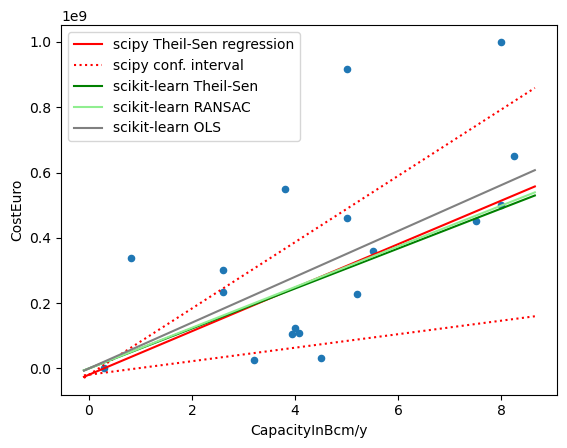

In [42]:
ax = terms_df_floating_toregress_dropdupes.plot.scatter('CapacityInBcm/y', 'CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred_f = ts_estimator_f.predict(xvals.reshape(-1,1))
r_pred_f = r_estimator_f.predict(xvals.reshape(-1,1))
ols_pred_f = ols_estimator_f.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope_f*xvals+ts_intercept_f, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope_f*xvals+ts_intercept_f, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope_f*xvals+ts_intercept_f, c='red', ls=':')

ax.plot(xvals, ts_pred_f, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred_f, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred_f, label='scikit-learn OLS', c='gray')

#ax.plot(

#ax.plot(xvals, s_slope*xvals+s_intercept, label = 'scipy.stats', c='orange')

ax.legend()

print(ols_estimator_f.coef_/1e6, "OLS")
print(ts_estimator_f.coef_/1e6, "TS")
print(r_estimator_f.estimator_.coef_/1e6, "R")
print(ts_slope_f/1e6, "scipy TS slope")
print(terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6, "straight-up mean")

#### onshore terminals

In [43]:
ts_estimator_o = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                 y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

r_estimator_o = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

ols_estimator_o = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                  y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

ts_slope_o, ts_intercept_o, ts_low_slope_o, ts_high_slope_o = scipy.stats.mstats.theilslopes(y=terms_df_onshore_toregress.CostEuro.tolist(), 
                                                                            x=terms_df_onshore_toregress['CapacityInBcm/y'].tolist(),
                                                                            alpha=0.1, )

s_slope_o, s_intercept_o = scipy.stats.mstats.siegelslopes(y=terms_df_onshore_toregress.CostEuro.tolist(), 
                                                       x=terms_df_onshore_toregress['CapacityInBcm/y'].tolist())

/Users/baird/mambaforge/envs/gem/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[83.06265718]] OLS
[125.] TS
[[81.41650426]] R
76.97100671181944 scipy TS slope


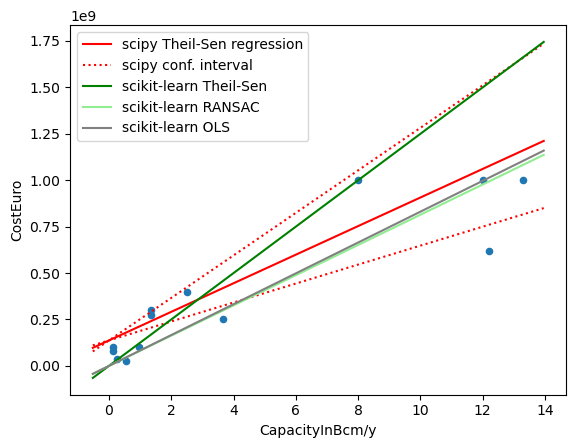

In [44]:
ax = terms_df_onshore_toregress_dropdupes.plot.scatter('CapacityInBcm/y', 'CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred_o = ts_estimator_o.predict(xvals.reshape(-1,1))
r_pred_o = r_estimator_o.predict(xvals.reshape(-1,1))
ols_pred_o = ols_estimator_o.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope_o*xvals+ts_intercept_o, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope_o*xvals+ts_intercept_o, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope_o*xvals+ts_intercept_o, c='red', ls=':')

ax.plot(xvals, ts_pred_o, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred_o, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred_o, label='scikit-learn OLS', c='gray')

#ax.plot(

#ax.plot(xvals, s_slope*xvals+s_intercept, label = 'scipy.stats', c='orange')

ax.legend()

print(ols_estimator_o.coef_/1e6, "OLS")
print(ts_estimator_o.coef_/1e6, "TS")
print(r_estimator_o.estimator_.coef_/1e6, "R")
print(ts_slope_o/1e6, "scipy TS slope")

## calculate floating costs (high and low estimates)

SMALLER MEAN

In [45]:
print(ols_estimator_f.coef_[0][0]/1e6)
print(ols_estimator_o.coef_[0][0]/1e6)

70.22029989097626
83.06265717569723


In [46]:
mean_cost_per_bcmy_floating = ols_estimator_f.coef_[0][0]/1e6
mean_cost_per_bcmy_onshore = ols_estimator_o.coef_[0][0]/1e6

terms_df_eu27_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
                                                 (terms_df_touse['Import/Export']=='Import')]

# do for floating
terms_df_eu27_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan

terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_eu27_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_eu27_import_future['CostEuro'].isna()
terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    terms_df_eu27_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/1020654288.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/1020654288.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \


LARGER MEAN

In [47]:
print(terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6)
print(terms_df_onshore_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6)

87.40097522988886
200.19259648538463


In [48]:
mean_cost_per_bcmy_floating = terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6
mean_cost_per_bcmy_onshore = terms_df_onshore_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

# terms_df_eu27_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
#                                                  (terms_df_touse['Import/Export']=='Import')]

# do for floating
terms_df_eu27_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan

terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_eu27_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_eu27_import_future['CostEuro'].isna()
terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    terms_df_eu27_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/1859383821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/1859383821.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \


In [49]:
terms_df_eu27_import_future['TotalEstCostEuroMillionsMean'] = \
    terms_df_eu27_import_future[['TotalEstCostEuroMillionsLow', 'TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/4095347764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsMean'] = \


### correct outliers/special cases

In [50]:
# Zeebrugge terminal is 116 million for BOTH expansion projects, so set one equal to zero so it's not counted twice
#T042601	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2024 Expansion
#T042602	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2026 Expansion
outliers_comboids = ['T042602']
terms_df_eu27_import_future.loc[
    terms_df_eu27_import_future.ComboID.isin(outliers_comboids),
    ['TotalEstCostEuroMillionsMean','TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = 0.0

# table of terminals in dev

In [51]:
terms_df_eu27_import_future['CapacityInBcm/y'].sum()

227.2

In [52]:
output_columns = ['Country',
                  #'TerminalName',
                  'TerminalNameUnitName',
                  #'UnitName',
                  'CapacityInBcm/y',
                  'Status',
                  #'Import/Export',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

terms_df_eu27_import_future['TerminalNameUnitName'] = (terms_df_eu27_import_future.TerminalName + ' ' + terms_df_eu27_import_future.UnitName).str.strip()
terms_df_eu27_import_future.sort_values(['Status','TerminalNameUnitName'],
                                        ascending=[True,True])[output_columns].replace(numpy.nan,'').style.hide_index()

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/3449440813.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TerminalNameUnitName'] = (terms_df_eu27_import_future.TerminalName + ' ' + terms_df_eu27_import_future.UnitName).str.strip()
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/3449440813.py:13: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_eu27_import_future.sort_values(['Status','TerminalNameUnitName'],


Country,TerminalNameUnitName,CapacityInBcm/y,Status,TotalEstCostEuroMillionsMean
Greece,Alexandroupolis FSRU,5.500000,Construction,360.000000
Cyprus,Cyprus LNG Terminal,0.820000,Construction,337.000000
Estonia,Paldiski FSRU,,Construction,500.000000
Germany,Stade FSRU,5.000000,Construction,394.053188
Belgium,Zeebrugge LNG Terminal 2024 Expansion,6.390000,Construction,116.000000
Belgium,Zeebrugge LNG Terminal 2026 Expansion,1.770000,Construction,0.000000
Poland,Świnoujście Polskie LNG Terminal Expansion 2,2.100000,Construction,297.418016
Greece,Argo FSRU,5.200000,Proposed,226.500000
Romania,Black Sea LNG Terminal Import Facility,,Proposed,
Germany,Brunsbüttel LNG Terminal,8.000000,Proposed,1000.000000


# table of future gas infra in EU countries

In [53]:
terms_df_eu27_import_future.groupby('Country')[['TotalEstCostEuroMillionsMean']].sum()

,TotalEstCostEuroMillionsMean
Country,
Belgium,116.000000
Croatia,576.674463
Cyprus,337.000000
Estonia,1150.000000
France,2447.708254
Germany,6790.674505
Greece,2311.583415
Ireland,854.907658
Italy,4375.933977


In [54]:
# table 1 shows country totals of pipeline length, cost, LNG capacity, cost, total cost
table2_columns = ['PipelineLengthKm','PipelineCostMillionEuro',
                  'LNGImportCapacityBcm/y','LNGTerminalCostMillionEuro','TotalCostMillionEuro']
table2_df = pandas.DataFrame(columns=table2_columns, index=region_df_touse.Country.tolist())

table2_df['PipelineLengthKm'] = country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['MergedKmByCountry'].sum()

table2_df['PipelineCostMillionEuro'] = country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['TotalEstCostEuroMillionsMean'].sum()

# add half of Trans-Adriatic expansion to Italy, half to Greece
#table2_df.loc['Greece','PipelineCostMillionEuro']+=1035/2
#table2_df.loc['Italy','PipelineCostMillionEuro']+=1035/2

table2_df['LNGImportCapacityBcm/y'] = terms_df_eu27_import_future.groupby('Country')['CapacityInBcm/y'].sum()
table2_df['LNGTerminalCostMillionEuro'] = terms_df_eu27_import_future.groupby('Country')['TotalEstCostEuroMillionsMean'].sum()
table2_df['TotalCostMillionEuro'] = table2_df.loc[:,('PipelineCostMillionEuro','LNGTerminalCostMillionEuro')].sum(axis=1)

if 'Total' in table2_df.index:
    table2_df.drop(index='Total', inplace=True)   
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df = table2_df.append(total)

else:
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df = table2_df.append(total)

# replace NaN with ''
table2_df.replace(numpy.nan, '', inplace=True)
table2_df.replace(0.0, '', inplace=True)


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/2538600389.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table2_df = table2_df.append(total)


In [55]:
table2_df#['LNGImportCapacityBcm/y'][:-1].replace('',numpy.nan).sum()

,PipelineLengthKm,PipelineCostMillionEuro,LNGImportCapacityBcm/y,LNGTerminalCostMillionEuro,TotalCostMillionEuro
Austria,59.39,178.776066,,,178.776066
Belgium,,,8.16,116.0,116.0
Bulgaria,1124.62,2577.931241,,,2577.931241
Croatia,870.54,1016.529627,10.2,576.674463,1593.204089
Cyprus,921.15,2684.692924,0.82,337.0,3021.692924
Czech Republic,157.95,218.52681,,,218.52681
Denmark,,,,,
Estonia,1.2,3.612246,6.17,1150.0,1153.612246
Finland,,,,,
France,,,18.47,2447.708254,2447.708254


# creating table 4 from report (nsew_eu)

In [56]:
import_projectids

['P0463',
 'P0479',
 'P0702',
 'P0732',
 'P0827',
 'P3206',
 'P1321',
 'P1324',
 'P3203',
 'P3335',
 'P1773',
 'P4399']

In [57]:
pipes_df_orig_gas.loc[pipes_df_orig_gas.ProjectID.isin(import_projectids)][['PipelineName','Wiki']]

,PipelineName,Wiki
249,Nigeria-Morocco Gas Pipeline,https://www.gem.wiki/Nigeria-Morocco_Gas_Pipeline
263,Israel Cyprus Gas Pipeline,https://www.gem.wiki/Israel_Cyprus_Gas_Pipeline
328,Ionian Adriatic Gas Pipeline,https://www.gem.wiki/Ionian_Adriatic_Gas_Pipeline
358,White Stream Gas Pipeline,https://www.gem.wiki/White_Stream_Gas_Pipeline
421,East Med Gas Pipeline,https://www.gem.wiki/East_Med_Gas_Pipeline
787,Bosnia and Herzegovina–Croatia South Interconn...,https://www.gem.wiki/Bosnia_and_Herzegovina%E2...
788,Cyprus-Turkey Gas Pipeline,https://www.gem.wiki/Cyprus-Turkey_Gas_Pipeline
985,Romania-Ukraine Interconnector,https://www.gem.wiki/Siret-Khotyn_Gas_Pipeline
1789,Trans-Adriatic Gas Pipeline,https://www.gem.wiki/Trans-Adriatic_Gas_Pipeline
1792,East Med Gas Pipeline,https://www.gem.wiki/East_Med_Gas_Pipeline


In [58]:
region_list = [western_eu,eastern_eu,southern_eu,northern_eu]
index_list = ['Western EU','Eastern EU','Southern EU','Northern EU']
project_list = []

table4_nsew = pandas.DataFrame(0, columns=['EstCostMillionEuroConstruction',
                                           'CostNumPipesConstruction',
                                           'CostNumTermsConstruction',
                                           'PipeLengthConstruction',
                                           
                                        'CapacityInBcm/yConstruction',
                                           'CapacNumPipesConstruction',
                                           'CapacNumTermsConstruction',
                                           'CapacPipesConstruction',
                                           'CapacTermsConstruction',
                                           'PipesProjectIDsConstruction',
                                           'TermsComboIDsConstruction',
                                           
                                        'EstCostMillionEuroProposed',
                                           'CostNumPipesProposed',
                                           'CostNumTermsProposed',
                                           'PipeLengthProposed',
                                           
                                        'CapacityInBcm/yProposed',
                                           'CapacNumPipesProposed',
                                           'CapacNumTermsProposed',
                                           'CapacPipesProposed',
                                           'CapacTermsProposed'
                                           'PipesProjectIDsProposed',
                                           'TermsComboIDsProposed',
                                           
                                          ], index=range(4))

terms_w_eu = pandas.DataFrame()
terms_n_eu = pandas.DataFrame()
terms_s_eu = pandas.DataFrame()
terms_e_eu = pandas.DataFrame()

pipes_w_eu = pandas.DataFrame()
pipes_n_eu = pandas.DataFrame()
pipes_s_eu = pandas.DataFrame()
pipes_e_eu = pandas.DataFrame()

for idx,row in table4_nsew.iterrows():
    
    for STATUS in ['Proposed','Construction']:
        
        # for proposed
        # for pipeline costs, we don't care about imports only, we also care about general pipelines
        pipeline_cost = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))]['TotalEstCostEuroMillionsMean'].sum()
        
        pipe_cost_num = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))].ProjectID.unique().size
        
        pipe_length = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))]['MergedKmByCountry'].sum()

        pipeline_capacity = pipes_df_orig_gas.loc[(pipes_df_orig_gas.ProjectID.isin(import_projectids)) &
                                (pipes_df_orig_gas.EndCountry.isin(region_list[idx])) &
                                (pipes_df_orig_gas.Status.isin([STATUS]))]['CapacityBcm/y'].sum()
        
        pipe_cap_num = pipes_df_orig_gas.loc[(pipes_df_orig_gas.ProjectID.isin(import_projectids)) &
                                (pipes_df_orig_gas.EndCountry.isin(region_list[idx])) &
                                (pipes_df_orig_gas.Status.isin([STATUS]))]['CapacityBcm/y'].count()
        
        pipe_projectids = pipes_df_orig_gas.loc[(pipes_df_orig_gas.ProjectID.isin(import_projectids)) &
                                (pipes_df_orig_gas.EndCountry.isin(region_list[idx])) &
                                (pipes_df_orig_gas.Status.isin([STATUS]))].PipelineName.tolist()
        
        # ****************************************

        terminal_cost = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['TotalEstCostEuroMillionsMean'].sum()
        term_num = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['TerminalName'].count()

        terminal_capacity = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['CapacityInBcm/y'].sum()
        term_comboids = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))].TerminalName.tolist()

        # pipelines are import only
        which_pipelines_df = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]) &
                               (country_ratios_df_touse.ProjectID.isin(import_projectids)))]
        which_terminals_df = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]
        
        #print(which_terminals_df.ComboID)

        if index_list[idx]=='Western EU':
            terms_w_eu = pandas.concat([terms_w_eu,which_terminals_df])
            pipes_w_eu = pandas.concat([pipes_w_eu,which_pipelines_df])
        if index_list[idx]=='Northern EU':
            terms_n_eu = pandas.concat([terms_n_eu,which_terminals_df])
            pipes_n_eu = pandas.concat([pipes_n_eu,which_pipelines_df])
        if index_list[idx]=='Eastern EU':
            terms_e_eu = pandas.concat([terms_e_eu,which_terminals_df])
            pipes_e_eu = pandas.concat([pipes_e_eu,which_pipelines_df])
        if index_list[idx]=='Southern EU':
            terms_s_eu = pandas.concat([terms_s_eu,which_terminals_df])
            pipes_s_eu = pandas.concat([pipes_s_eu,which_pipelines_df])

        table4_nsew.loc[idx, 'EstCostMillionEuro'+STATUS] += terminal_cost+pipeline_cost
        table4_nsew.loc[idx, 'CapacityInBcm/y'+STATUS] += terminal_capacity+pipeline_capacity
        table4_nsew.loc[idx, 'CapacTerms'+STATUS] = terminal_capacity
        table4_nsew.loc[idx, 'CapacPipes'+STATUS] = pipeline_capacity
        table4_nsew.loc[idx, 'CostNumTerms'+STATUS] = term_num
        table4_nsew.loc[idx, 'CapacNumTerms'+STATUS] = term_num
        table4_nsew.loc[idx, 'CostNumPipes'+STATUS] = pipe_cost_num
        table4_nsew.loc[idx, 'CapacNumPipes'+STATUS] = pipe_cap_num
        table4_nsew.loc[idx, 'PipeLength'+STATUS] = pipe_length
        table4_nsew.loc[idx, 'PipesProjectIDs'+STATUS] = '\n'.join(pipe_projectids)
        table4_nsew.loc[idx, 'TermsComboIDs'+STATUS] = '\n'.join(term_comboids)

table4_nsew.index = index_list

# add trans-adriatic
#table4_nsew.loc['Southern EU','EstCostMillionEuroProposed'] += 1035.

# cost figure/table data

sum of Table 1 columns...

In [59]:
country_ratios_df_touse.columns

Index(['PipelineName', 'SegmentName', 'ProjectID', 'Country',
       'LengthEstimateKmByCountry', 'LengthEstimateKm',
       'LengthPerCountryFraction', 'Owner', 'Region', 'PipelineBubbleRegion',
       'CapacityBcm/y', 'Status', 'Fuel', 'CapacityBcm/yPerCountry',
       'CapacityBOEd', 'CapacityBOEdPerCountry', 'FID', 'CostUSD', 'CostEuro',
       'LengthKnownKm', 'LengthKnownKmByCountry', 'MergedKmByPipeline',
       'CostUSDPerKm', 'CostEuroPerKm', 'MergedKmByCountry', 'Owner', 'Parent',
       'H2Status', 'H2Type', 'CancelledYear', 'ProposalYear',
       'ConstructionYear', 'ShelvedYear', 'StartYearEarliest',
       'TotalEstCostEuroMillionsHigh', 'TotalEstCostEuroMillionsLow',
       'TotalEstCostEuroMillionsMean'],
      dtype='object')

In [60]:
figure1_table_columns = ['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro','Total']
figure1_table_df = pandas.DataFrame(0, columns=figure1_table_columns, index=region_df_touse.Country,)


# for proposed
figure1_table_df['TotalProposedCostMillionEuro'] = \
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(
    ['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalProposedCostMillionEuro'] = \
figure1_table_df['TotalProposedCostMillionEuro'].add( \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                    fill_value=0)

figure1_table_df.loc['Italy','TotalProposedCostMillionEuro'] += 1035/2.
figure1_table_df.loc['Greece','TotalProposedCostMillionEuro'] += 1035/2.

# for construction
figure1_table_df['TotalConstructionCostMillionEuro'] = \
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalConstructionCostMillionEuro'] = \
figure1_table_df['TotalConstructionCostMillionEuro'].add( \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                         fill_value=0, axis=0)

figure1_table_df['Total'] = \
figure1_table_df[['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro']].sum(axis=1)
figure1_table_df.sort_values(['Total','Country'], ascending=[False, True], inplace=True)

figure1_table_df.replace(numpy.nan, '', inplace=True)
figure1_table_df.replace(0, '', inplace=True)

In [61]:
figure1_table_df

,TotalConstructionCostMillionEuro,TotalProposedCostMillionEuro,Total
Country,,,
Greece,440.0,10651.500673,11091.500674
Italy,822.85321,9395.951897,10218.805107
Germany,394.053188,8154.496736,8548.549923
Poland,1552.061112,1983.479211,3535.540323
Cyprus,337.0,2684.692924,3021.692924
Spain,,2850.553638,2850.553638
Romania,,2700.791303,2700.791303
Bulgaria,76.65764,2501.273601,2577.931241
France,,2447.708254,2447.708254


# Lena's cost request

In [62]:
#lena1_table_columns = ['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro','Total']
lena1_table_df = pandas.DataFrame(index=region_df_touse.Country)

# for proposed
lena1_table_df['TotalProposedCostMillionEuroPipelines'] = \
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

lena1_table_df['TotalProposedCostMillionEuroTerminals'] = \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

#lena1_table_df.loc['Italy','TotalProposedCostMillionEuro'] += 1035/2.
#lena1_table_df.loc['Greece','TotalProposedCostMillionEuro'] += 1035/2. # TAP pipeline, not necessary anymore

# for construction
lena1_table_df['TotalConstructionCostMillionEuroPipelines'] = \
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

lena1_table_df['TotalConstructionCostMillionEuroTerminals'] = \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

lena1_table_df['Total'] = \
lena1_table_df.sum(axis=1)
lena1_table_df.sort_values(['Total','Country'], ascending=[False, True], inplace=True)

#lena1_table_df.replace(numpy.nan, '', inplace=True)
#lena1_table_df.replace(0, '', inplace=True)

In [63]:
lena1_table_df.replace(numpy.nan,'').replace(0,'')

,TotalProposedCostMillionEuroPipelines,TotalProposedCostMillionEuroTerminals,TotalConstructionCostMillionEuroPipelines,TotalConstructionCostMillionEuroTerminals,Total
Country,,,,,
Greece,8182.417258,1951.583415,80.0,360.0,10574.000674
Italy,4502.51792,4375.933977,822.85321,,9701.305107
Germany,1757.875419,6396.621317,,394.053188,8548.549923
Poland,1363.479211,620.0,1254.643096,297.418016,3535.540323
Cyprus,2684.692924,,,337.0,3021.692924
Spain,1717.532623,1133.021015,,,2850.553638
Romania,2700.791303,,,,2700.791303
Bulgaria,2501.273601,,76.65764,,2577.931241
France,,2447.708254,,,2447.708254


## figure for Lena

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/3959272423.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_to_sample = matplotlib.cm.get_cmap('Oranges')
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_42746/3959272423.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_to_sample = matplotlib.cm.get_cmap('Purples')


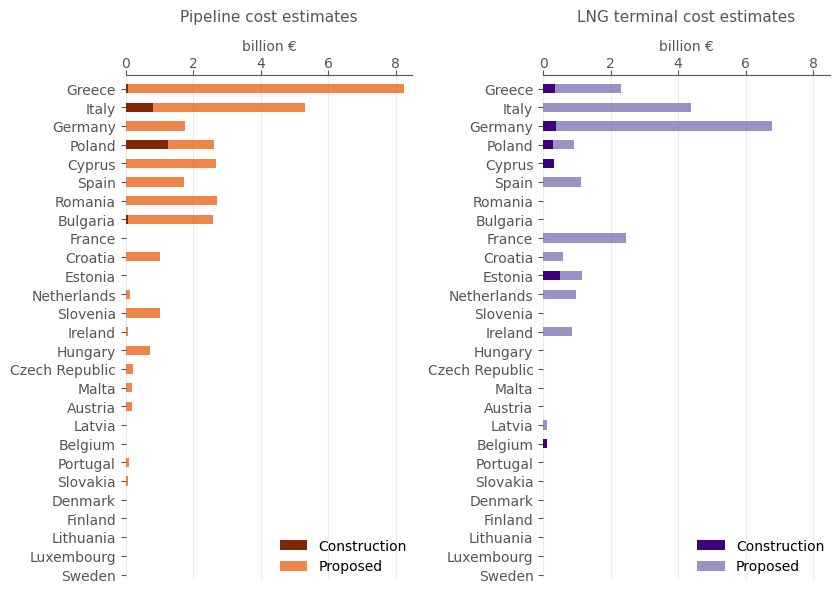

In [64]:
font_size = 10
axis_color='0.333'

fig = mp.figure(figsize=(8.5,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nbars=27

# pipelines
cmap_to_sample = matplotlib.cm.get_cmap('Oranges')
ax1.barh(numpy.arange(nbars), 
        lena1_table_df.TotalConstructionCostMillionEuroPipelines.replace(numpy.nan,0).values[::-1]/1e3, 
        facecolor=cmap_to_sample(0.999), 
        label='Construction', height=0.5, alpha=1)

ax1.barh(numpy.arange(nbars),
        lena1_table_df.TotalProposedCostMillionEuroPipelines.replace(numpy.nan,0).values[::-1]/1e3, 
        left=lena1_table_df.TotalConstructionCostMillionEuroPipelines.replace(numpy.nan,0).values[::-1]/1e3, 
        facecolor=cmap_to_sample(0.666), 
        label='Proposed', height=0.5, alpha=0.75)

ax1.set_yticks(numpy.arange(nbars))
ax1.set_yticklabels(lena1_table_df.index[::-1])
ax1.tick_params(labelsize=font_size)
ax1.tick_params('x', pad=0)
ax1.set_xlim(0,8.5)
#ax.set_ylim(-.75,19.75)
ax1.set_ylim(-.25,26.75)
ax1.set_xlabel('billion €', size=font_size, color=axis_color)
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.legend(fontsize=font_size, frameon=False, loc='lower right', borderaxespad=0)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_color(axis_color)
ax1.spines['left'].set_color(axis_color)
ax1.tick_params(colors=axis_color)
ax1.xaxis.grid([2,4,6,8], alpha=0.25)
ax1.set_axisbelow(True)

# terminals
cmap_to_sample = matplotlib.cm.get_cmap('Purples')
ax2.barh(numpy.arange(nbars), 
        lena1_table_df.TotalConstructionCostMillionEuroTerminals.replace(numpy.nan,0).values[::-1]/1e3, 
        facecolor=cmap_to_sample(0.999), 
        label='Construction', height=0.5, alpha=1)

ax2.barh(numpy.arange(nbars),
        lena1_table_df.TotalProposedCostMillionEuroTerminals.replace(numpy.nan,0).values[::-1]/1e3, 
        left=lena1_table_df.TotalConstructionCostMillionEuroTerminals.replace(numpy.nan,0).values[::-1]/1e3, 
        facecolor=cmap_to_sample(0.666), 
        label='Proposed', height=0.5, alpha=0.75)

ax2.set_yticks(numpy.arange(nbars))
ax2.set_yticklabels(lena1_table_df.index[::-1])
ax2.tick_params(labelsize=font_size)
ax2.tick_params('x', pad=0)
ax2.set_xlim(0,8.5)
#ax.set_ylim(-.75,19.75)
ax2.set_ylim(-.25,26.75)
ax2.set_xlabel('billion €', size=font_size, color=axis_color)
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.legend(fontsize=font_size, frameon=False, loc='lower right', borderaxespad=0)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_color(axis_color)
ax2.spines['left'].set_color(axis_color)
ax2.tick_params(colors=axis_color)
ax2.xaxis.grid([2,4,6,8], alpha=0.25)
ax2.set_axisbelow(True)

ax1.text(s='Pipeline cost estimates', x=0.5, y=1.1, transform=ax1.transAxes,
         ha='center', va='bottom', fontsize=font_size+1, color=axis_color)

ax2.text(s='LNG terminal cost estimates', x=0.5, y=1.1, transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=font_size+1, color=axis_color)

fig.tight_layout()
fig.savefig('ecf-figure-drafts/pipeline-and-terminal-costs.pdf', bbox_inches='tight', transparent=True)
fig.savefig('ecf-figure-drafts/pipeline-and-terminal-costs.png', bbox_inches='tight', dpi=600)

# Stijn's figure request

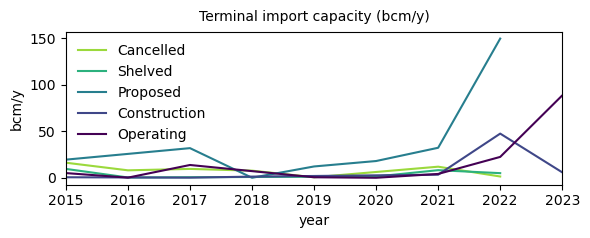

In [443]:
# proposal year
# construction year
# shelved year
# cancelled year
# retired year?
fig = mp.figure(figsize=(6,2.5))
font_size = 10

cmap_to_sample = matplotlib.cm.get_cmap('viridis_r')

const_years = terms_df_touse_imports.groupby('ConstructionYear')[['CapacityInBcm/y']].sum()
prop_years = terms_df_touse_imports.groupby('ProposalYear')[['CapacityInBcm/y']].sum()
op_years = terms_df_touse_imports.groupby('StartYearEarliest')[['CapacityInBcm/y']].sum()
shelved_years = terms_df_touse_imports.groupby('ShelvedYear')[['CapacityInBcm/y']].sum()
canc_years = terms_df_touse_imports.groupby('CancelledYear')[['CapacityInBcm/y']].sum()

df_list = [op_years,
           const_years,
           prop_years,
           shelved_years,
           canc_years][::-1]
df_list_labels = ['Operating',
                  'Construction',
                  'Proposed',
                  'Shelved',
                  'Cancelled'][::-1]

ax = fig.add_subplot(111)

i=0
for df,label in zip(df_list,df_list_labels):
    if '' in df.index:
        df.drop(index='', inplace=True)
    ax.plot(df.index, df['CapacityInBcm/y'], label=label, color=cmap_to_sample(numpy.linspace(0.15,.999,df_list.__len__())[i]))
    i+=1


ax.set_xlim(2015,2023)
ax.set_ylabel('bcm/y', fontsize=font_size)
ax.set_xlabel('year', fontsize=font_size)

ax.legend(fontsize=font_size, frameon=False, loc=0)#
, borderaxespad=0)
ax.tick_params(labelsize=font_size)

ax.text(s='Terminal import capacity (bcm/y)', y=1.05, x=0.5,
        ha='center', va='bottom', fontsize=font_size, transform=ax.transAxes)

fig.tight_layout()
fig.savefig('ecf-figure-drafts/status_and_year_terminals-capacity.pdf', bbox_inches='tight', transparent=True)
fig.savefig('ecf-figure-drafts/status_and_year_terminals-capacity.png', bbox_inches='tight', dpi=600)

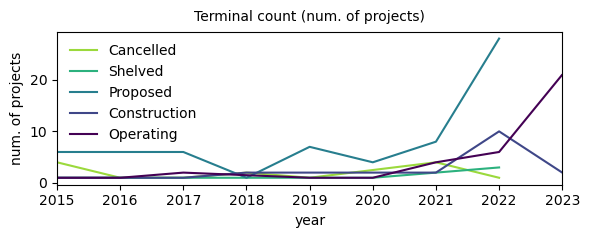

In [444]:
# proposal year
# construction year
# shelved year
# cancelled year
# retired year?
fig = mp.figure(figsize=(6,2.5))
font_size = 10

cmap_to_sample = matplotlib.cm.get_cmap('viridis_r')

const_years = terms_df_touse_imports.groupby('ConstructionYear')[['TerminalName']].count()
prop_years = terms_df_touse_imports.groupby('ProposalYear')[['TerminalName']].count()
op_years = terms_df_touse_imports.groupby('StartYearEarliest')[['TerminalName']].count()
shelved_years = terms_df_touse_imports.groupby('ShelvedYear')[['TerminalName']].count()
canc_years = terms_df_touse_imports.groupby('CancelledYear')[['TerminalName']].count()

df_list = [op_years,
           const_years,
           prop_years,
           shelved_years,
           canc_years][::-1]
df_list_labels = ['Operating',
                  'Construction',
                  'Proposed',
                  'Shelved',
                  'Cancelled'][::-1]

ax = fig.add_subplot(111)

i=0
for df,label in zip(df_list,df_list_labels):
    if '' in df.index:
        df.drop(index='', inplace=True)
    ax.plot(df.index, df['TerminalName'], label=label, color=cmap_to_sample(numpy.linspace(0.15,.999,df_list.__len__())[i]))
    i+=1


ax.set_xlim(2015,2023)
ax.set_ylabel('num. of projects', fontsize=font_size)
ax.set_xlabel('year', fontsize=font_size)

ax.legend(fontsize=font_size, frameon=False, loc=0)#
, borderaxespad=0)
ax.tick_params(labelsize=font_size)

ax.text(s='Terminal count (num. of projects)', y=1.05, x=0.5,
        ha='center', va='bottom', fontsize=font_size, transform=ax.transAxes)

fig.tight_layout()
fig.savefig('ecf-figure-drafts/status_and_year_terminals-count.pdf', bbox_inches='tight', transparent=True)
fig.savefig('ecf-figure-drafts/status_and_year_terminals-count.png', bbox_inches='tight', dpi=600)

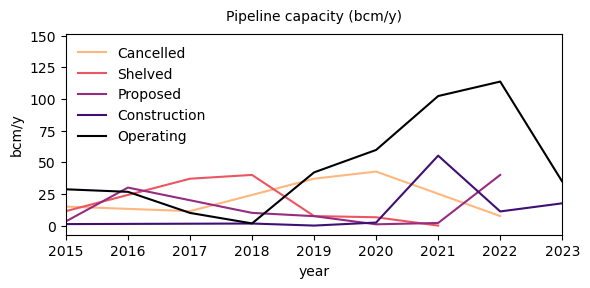

In [429]:
# proposal year
# construction year
# shelved year
# cancelled year
# retired year?
fig = mp.figure(figsize=(6,3))
font_size = 10

cmap_to_sample = matplotlib.cm.get_cmap('magma_r')

const_years = pipes_df_touse.groupby('ConstructionYear')[['CapacityBcm/y']].sum()
prop_years = pipes_df_touse.groupby('ProposalYear')[['CapacityBcm/y']].sum()
op_years = pipes_df_touse.groupby('StartYearEarliest')[['CapacityBcm/y']].sum()
shelved_years = pipes_df_touse.groupby('ShelvedYear')[['CapacityBcm/y']].sum()
canc_years = pipes_df_touse.groupby('CancelledYear')[['CapacityBcm/y']].sum()

df_list = [op_years,
           const_years,
           prop_years,
           shelved_years,
           canc_years][::-1]
df_list_labels = ['Operating',
                  'Construction',
                  'Proposed',
                  'Shelved',
                  'Cancelled'][::-1]

ax = fig.add_subplot(111)

i=0
for df,label in zip(df_list,df_list_labels):
    if '' in df.index:
        df.drop(index='', inplace=True)
    ax.plot(df.index, df['CapacityBcm/y'], label=label, color=cmap_to_sample(numpy.linspace(0.15,.999,df_list.__len__())[i]))
    i+=1


ax.set_xlim(2015,2023)
ax.set_ylabel('bcm/y', fontsize=font_size)
ax.set_xlabel('year', fontsize=font_size)

ax.legend(fontsize=font_size, frameon=False, loc=0)#
, borderaxespad=0)
ax.tick_params(labelsize=font_size)

ax.text(s='Pipeline capacity (bcm/y)', y=1.05, x=0.5,
        ha='center', va='bottom', fontsize=font_size, transform=ax.transAxes)

fig.tight_layout()
fig.savefig('ecf-figure-drafts/status_and_year_pipelines-capacity.pdf', bbox_inches='tight', transparent=True)
fig.savefig('ecf-figure-drafts/status_and_year_pipelines-capacity.png', bbox_inches='tight', dpi=600)

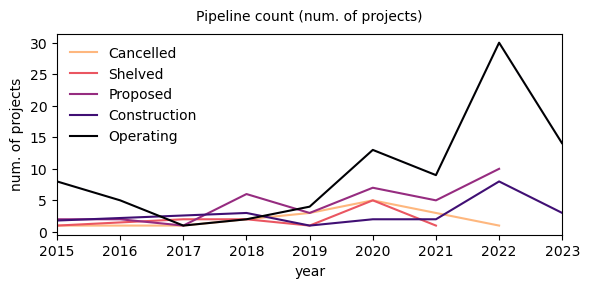

In [436]:
# proposal year
# construction year
# shelved year
# cancelled year
# retired year?
fig = mp.figure(figsize=(6,3))
font_size = 10

cmap_to_sample = matplotlib.cm.get_cmap('magma_r')

const_years = pipes_df_touse.groupby('ConstructionYear')[['LengthMergedKm']].count()
prop_years = pipes_df_touse.groupby('ProposalYear')[['LengthMergedKm']].count()
op_years = pipes_df_touse.groupby('StartYearEarliest')[['LengthMergedKm']].count()
shelved_years = pipes_df_touse.groupby('ShelvedYear')[['LengthMergedKm']].count()
canc_years = pipes_df_touse.groupby('CancelledYear')[['LengthMergedKm']].count()

df_list = [op_years,
           const_years,
           prop_years,
           shelved_years,
           canc_years][::-1]
df_list_labels = ['Operating',
                  'Construction',
                  'Proposed',
                  'Shelved',
                  'Cancelled'][::-1]

ax = fig.add_subplot(111)

i=0
for df,label in zip(df_list,df_list_labels):
    if '' in df.index:
        df.drop(index='', inplace=True)
    ax.plot(df.index, df['LengthMergedKm'], label=label, color=cmap_to_sample(numpy.linspace(0.15,.999,df_list.__len__())[i]))
    i+=1


ax.set_xlim(2015,2023)
ax.set_ylabel('num. of projects', fontsize=font_size)
ax.set_xlabel('year', fontsize=font_size)

ax.legend(fontsize=font_size, frameon=False, loc=0)#
, borderaxespad=0)
ax.tick_params(labelsize=font_size)

ax.text(s='Pipeline count (num. of projects)', y=1.05, x=0.5,
        ha='center', va='bottom', fontsize=font_size, transform=ax.transAxes)

fig.tight_layout()
fig.savefig('ecf-figure-drafts/status_and_year_pipelines-count.pdf', bbox_inches='tight', transparent=True)
fig.savefig('ecf-figure-drafts/status_and_year_pipelines-count.png', bbox_inches='tight', dpi=600)

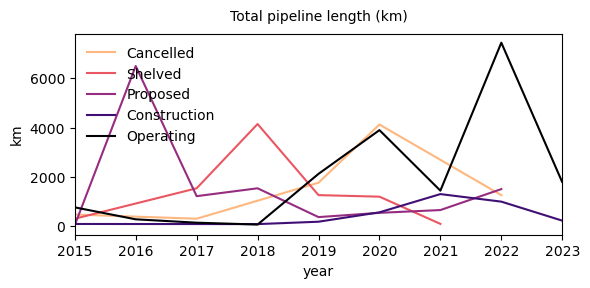

In [435]:
# proposal year
# construction year
# shelved year
# cancelled year
# retired year?
fig = mp.figure(figsize=(6,3))
font_size = 10

cmap_to_sample = matplotlib.cm.get_cmap('magma_r')

const_years = pipes_df_touse.groupby('ConstructionYear')[['LengthMergedKm']].sum()
prop_years = pipes_df_touse.groupby('ProposalYear')[['LengthMergedKm']].sum()
op_years = pipes_df_touse.groupby('StartYearEarliest')[['LengthMergedKm']].sum()
shelved_years = pipes_df_touse.groupby('ShelvedYear')[['LengthMergedKm']].sum()
canc_years = pipes_df_touse.groupby('CancelledYear')[['LengthMergedKm']].sum()

df_list = [op_years,
           const_years,
           prop_years,
           shelved_years,
           canc_years][::-1]
df_list_labels = ['Operating',
                  'Construction',
                  'Proposed',
                  'Shelved',
                  'Cancelled'][::-1]

ax = fig.add_subplot(111)

i=0
for df,label in zip(df_list,df_list_labels):
    if '' in df.index:
        df.drop(index='', inplace=True)
    ax.plot(df.index, df['LengthMergedKm'], label=label, color=cmap_to_sample(numpy.linspace(0.15,.999,df_list.__len__())[i]))
    i+=1


ax.set_xlim(2015,2023)
ax.set_ylabel('km', fontsize=font_size)
ax.set_xlabel('year', fontsize=font_size)

ax.legend(fontsize=font_size, frameon=False)#, loc=0)#, borderaxespad=0)
ax.tick_params(labelsize=font_size)

ax.text(s='Total pipeline length (km)', y=1.05, x=0.5,
        ha='center', va='bottom', fontsize=font_size, transform=ax.transAxes)

fig.tight_layout()
fig.savefig('ecf-figure-drafts/status_and_year_pipelines-km.pdf', bbox_inches='tight', transparent=True)
fig.savefig('ecf-figure-drafts/status_and_year_pipelines-km.png', bbox_inches='tight', dpi=600)

# report numbers

In [253]:
# key points
# num of gas pipelines under const in EU
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['MergedKmByCountry'].sum()

1458.41

In [646]:
# total cost
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['TotalEstCostEuroMillionsLow'].sum()

1925.5585489067287

In [647]:
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['TotalEstCostEuroMillionsHigh'].sum()

2549.973835715706

In [648]:
# number of distinct projects
unique_const = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))&
                                          (country_ratios_df_touse.Country.isin(region_df_touse.Country))].ProjectID.unique().tolist()
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_const)]['LengthMergedKm'].mean())
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_const)]['LengthMergedKm'].size)

97.79375
16


In [649]:
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['MergedKmByCountry'].sum()

11824.029999999999

In [650]:
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['TotalEstCostEuroMillionsLow'].sum()

25857.754656690784

In [651]:
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['TotalEstCostEuroMillionsHigh'].sum()

32437.46006053793

In [652]:
# number of distinct projects
unique_prop = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                                         (country_ratios_df_touse.Country.isin(region_df_touse.Country))].ProjectID.unique().tolist()
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_prop)]['LengthMergedKm'].mean())
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_prop)]['LengthMergedKm'].size)

244.75926829268292
83


# how many announced since war started?

# commissioned in 2022/2023

In [653]:
pipes_df_touse.loc[(pipes_df_touse.Status=='Operating')&
                   (pipes_df_touse.StartYearEarliest==2022)][['PipelineName',
                                                              'Wiki',
                                                              'Countries',
                                                              'CapacityBcm/y',
                                                              'CostEuro',
                                                              'LengthKnownKm']].set_index('PipelineName')

,Wiki,Countries,CapacityBcm/y,CostEuro,LengthKnownKm
PipelineName,,,,,
Baltic Pipe Project,https://www.gem.wiki/Baltic_Pipe_Project,"Norway, Denmark, Sweden, Poland",10.0,2.100000e+09,612.5
Gas Interconnection Poland-Lithuania,https://www.gem.wiki/Gas_Interconnection_Poland-Lithuania_(GIPL),"Poland, Lithuania",2.4,5.660000e+08,508.0
Poland-Slovakia Gas Pipeline,https://www.gem.wiki/Poland-Slovakia_Gas_Pipeline,"Poland, Slovakia",5.7,2.700000e+08,165.0
Strachocina-Pogórska-Wola Gas Pipeline,https://www.gem.wiki/Strachocina_Pog%C3%B3rska_Wola_Pipeline,Poland,NaN,1.444037e+08,97.0
Medgaz Gas Pipeline,https://www.gem.wiki/Medgaz_Gas_Pipeline,"Algeria, Spain",2.7,NaN,0.0
Beglej-Dermantsi-Batultsi-Kalugerovo Pipeline,https://www.gem.wiki/Beglej-Dermantsi-Batultsi-Kalugerovo_Pipeline,Bulgaria,NaN,NaN,58.0
Baltic Pipe Project,https://www.gem.wiki/Goleni%C3%B3w-Lw%C3%B3wek_Gas_Pipeline,Poland,NaN,NaN,122.0
Baltic Pipe Project,https://www.gem.wiki/Goleni%C3%B3w-Lw%C3%B3wek_Gas_Pipeline,Poland,NaN,NaN,69.0
Midia Gas Pipeline,https://www.gem.wiki/Midia_Gas_Pipeline,Romania,1.0,NaN,126.0


In [654]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status=='Operating')&
                           (terms_df_touse_imports.StartYearEarliest.isin([2022,2023]))][['ComboID',
                                                                              'TerminalName',
                                                                              'UnitName',
                                                                              'Wiki',
                                                                              'Country',
                                                                              'CapacityInBcm/y',
                                                                              'CostEuro',
                                                                              'StartYear1','StartMonth1']].set_index('TerminalName').replace(numpy.nan,'')

,ComboID,UnitName,Wiki,Country,CapacityInBcm/y,CostEuro,StartYear1,StartMonth1
TerminalName,,,,,,,,
Hamina LNG Terminal,T043800,,https://www.gem.wiki/Hamina_LNG_Terminal,Finland,0.14,100000000,2022,10
Revithoussa LNG Terminal,T046201,FSU Capacity Expansion,https://www.gem.wiki/Revithoussa_LNG_Terminal,Greece,0.83,,2022,11
Świnoujście Polskie LNG Terminal,T049801,Expansion,https://www.gem.wiki/%c5%9awinouj%c5%9bcie_Polskie_LNG_Terminal,Poland,1.20,427000000,2022,1
Wilhelmshaven FSRU,T045800,,https://www.gem.wiki/Wilhelmshaven_FSRU,Germany,7.50,450000000,2022,12
Inkoo FSRU,T106400,,https://www.gem.wiki/Inkoo_FSRU,Finland,5.00,460000000,2023,1
Eemshaven FSRU,T099700,,https://www.gem.wiki/Eemshaven_FSRU,Netherlands,8.00,500000000,2022,10
Lubmin FSRU,T107700,Phase 1,https://www.gem.wiki/Lubmin_FSRU,Germany,4.50,33333333.33,2023,1


## starting in 2023 under const

In [655]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status.isin(['Construction','Proposed']))&
                           (terms_df_touse_imports.StartYearEarliest.isin([2023,2024,2025,2026,2027,2028,2029,2030]))].groupby(['StartYearEarliest',
                                                                                                           'Status'])[['CapacityInBcm/y']].sum()

CapacityInBcm/y
StartYearEarliest Status                       
2023              Construction            20.60
                  Proposed                58.07
2024              Construction             7.21
                  Proposed                30.38
2025              Proposed                43.15
2026              Construction             1.77
                  Proposed                41.00
2030              Proposed                 7.00

# existing capacity

In [656]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Operating']))&
                   (terms_df_touse['Import/Export']=='Import')]['CapacityInBcm/y'].sum()

191.98

In [657]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Operating']))&
                   (terms_df_touse['Import/Export']=='Import')
                  ].groupby('StartYear1')[['CapacityInBcm/y']].sum(min_count=0).cumsum()

,CapacityInBcm/y
StartYear1,
1969,17.14
1971,20.54
1972,22.17
1980,33.05
1987,42.03
1988,53.86
1989,65.69
2000,72.63
2003,79.57


In [658]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
                   (terms_df_touse['Import/Export']=='Import')
                  ].groupby('StartYearEarliest')[['CapacityInBcm/y']].sum()#.cumsum()

,CapacityInBcm/y
StartYearEarliest,
2023,78.67
2024,37.59
2025,43.15
2026,42.77
2030,7.00


proposed since 2022

In [659]:
terms_df_touse_imports.loc[terms_df_touse_imports.ProposalYear==2022]['CapacityInBcm/y'].sum()

129.28000000000003

began construction since 2022

In [660]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status.isin(['Construction','Operating']))&
                           (terms_df_touse_imports.ConstructionYear==2022)]['CapacityInBcm/y'].sum()

39.33

started since 2022

In [661]:
terms_df_touse_imports.loc[terms_df_touse_imports.StartYearEarliest.isin([2022,2023])]['CapacityInBcm/y'].sum()

111.00999999999999

# cancellations per year

# hydrogen exploring

In [662]:
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.H2Status!='']
pipes_df_touse_h2.H2Status.unique()

array(['Speculative (H2 only)', 'Pre-construction (H2 only)', 'Proposed'],
      dtype=object)

In [663]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.Fuel=='Hydrogen'][['ProjectID','Status','H2Status']]

,ProjectID,Status,H2Status
1305,P2477,Proposed,Proposed
2482,P4383,Proposed,Proposed
2483,P4384,Proposed,Proposed
2484,P4385,Proposed,Proposed
2486,P4388,Proposed,Proposed
...,...,...,...
3209,P5116,Operating,Pre-construction (H2 only)
3210,P5117,Proposed,Proposed
3211,P5118,Proposed,Speculative (H2 only)
3212,P5119,Proposed,Proposed


In [664]:
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Pre-construction (H2 only)'].shape)
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Speculative (H2 only)'].shape)
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Proposed'].shape)

(15, 89)
(63, 89)
(117, 89)


In [665]:
117+15+63

195

In [666]:
pipes_df_touse_h2.groupby('H2Status')[['LengthMergedKm']].count()#.sum()

,LengthMergedKm
H2Status,
Pre-construction (H2 only),12
Proposed,114
Speculative (H2 only),48


In [675]:
country_ratios_df_touse.loc[(country_ratios_df_touse.H2Status!='')&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(['H2Status'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)




,MergedKmByCountry
H2Status,
Pre-construction (H2 only),1011.61
Proposed,16338.36
Speculative (H2 only),4436.00


In [676]:
country_ratios_df_touse.loc[(country_ratios_df_touse.H2Status!='')&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(['H2Type'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)


,MergedKmByCountry
H2Type,
new - blended,2256.62
new - unknown,1998.36
repurposed - blended,17054.74
repurposed - unknown,476.25


In [678]:
country_ratios_df_touse.loc[(country_ratios_df_touse.H2Status!='')&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(['H2Status','H2Type'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)


MergedKmByCountry
H2Status                   H2Type                                 
Pre-construction (H2 only) repurposed - blended             535.36
                           repurposed - unknown             476.25
Proposed                   new - blended                   2097.87
                           new - unknown                   1409.00
                           repurposed - blended           12831.49
Speculative (H2 only)      new - blended                    158.75
                           new - unknown                    589.36
                           repurposed - blended            3687.89

In [585]:
2256.62+1998.36

4254.98

In [586]:
17054.74+476.25

17530.99

In [489]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('blended')|
                      pipes_df_touse_h2.H2Type.str.contains('unknown')].shape

(178, 89)

In [494]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('new')]['LengthMergedKm'].sum()

11602.699999999999

In [493]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('repurposed')]['LengthMergedKm'].sum()

18879.12

In [491]:
178/195

0.9128205128205128

In [490]:
pipes_df_touse_h2.shape

(195, 89)

In [477]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Pre-construction (H2 only)']['LengthMergedKm'].sum()

2055.88

* how many H2 pipelines are planning to be 100%? blended?
  * A: really, none; the Malta-Italy Gas Pipeline is actually seeming realistic-ish but has language about "up to 100%" rather than a confirmation

## hydrogen table 1

In [478]:
country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].MergedKmByCountry.sort_values()

2162       0.00
2051       0.00
2037       0.00
2036       0.00
3165       0.00
         ...   
1742     427.00
1532     500.71
1533     749.29
829     1110.45
1558    2765.00
Name: MergedKmByCountry, Length: 175, dtype: float64

In [479]:
# country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].groupby(
#     ['H2Status','Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].groupby(
    ['Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

,MergedKmByCountry
Country,
Germany,3826.63
Bulgaria,3312.03
Italy,2551.77
Spain,2012.82
Romania,1913.22
France,1430.82
Croatia,893.49
Hungary,839.10
Netherlands,825.25
